In [1]:
import io
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import copy
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp, retEEGexp

In [4]:
%matplotlib notebook

## EEGexp class

In [5]:
# rec_folder = r'E:\eeg_pilot\mouse000000\estim_vis_test_2020-09-10\experiment1\recording1' # this is the test
rec_folder = r'S:\mouse666193\pilot_aw_psi_2023-02-16_10-55-48\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

This data does not contain an EEG recording.
Experiment type: electrical stimulation


## retEEGexp class

In [6]:
print(exp.mouse)
print(exp.experiment_type)
print(exp.stim_instruction_files)
print(exp.stimulus_log_file)

666193
electrical stimulation
{'sensory': [], 'electrical': ['S:\\mouse666193\\pilot_aw_psi_2023-02-16_10-55-48\\experiment1\\recording1\\stimulation_protocol_120tr_40uA.dat'], 'opto': []}
S:\mouse666193\pilot_aw_psi_2023-02-16_10-55-48\experiment1\recording1\estim_log.csv


In [7]:
sync_data = exp._load_sync_dataset()
print(sync_data.line_labels)

['barcodes', 'opto_sync', 'frames', 'behavior_sweep', 'photodiode', 'sweep', '', 'behavior_vsync', 'eyetracking', 'behavior', 'rotA', 'rotB', 'estim_sync', 'estim_sweep', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', '']


## Sensory stim

This is from NP4 with a digital photodiode.<br>Load behavior_sweep, behavior_sync, and photodiode rising and falling edges.

In [8]:
# behavior_sweep
sweep_rising = sync_data.get_edges(keys=('behavior_sweep',), kind='rising', units='seconds')
sweep_falling = sync_data.get_edges(keys=('behavior_sweep',), kind='falling', units='seconds')
# behavior_vsync
vsync_rising = sync_data.get_edges(keys=('behavior_vsync',), kind='rising', units='seconds')
vsync_falling = sync_data.get_edges(keys=('behavior_vsync',), kind='falling', units='seconds')
# photodiode
pd_rising = sync_data.get_edges(keys=('photodiode',), kind='rising', units='seconds')
pd_falling = sync_data.get_edges(keys=('photodiode',), kind='falling', units='seconds')

In [9]:
if len(sweep_rising) == 0:
    between_sweep_inds = np.argwhere(np.diff(vsync_rising) > 10.).flatten()
    sweep_rising = np.concatenate(([vsync_rising[0]-1.], vsync_rising[between_sweep_inds]+2.))
    sweep_falling = np.concatenate((vsync_rising[between_sweep_inds]+1., [vsync_rising[-1]+1.]))

In [9]:
print('behavior_sweep info')
print('number of rising/falling: %d/%d' % (len(sweep_rising), len(sweep_falling)))
print('first rising: %f' % sweep_rising[0])
print('first falling: %f' % sweep_falling[0])

behavior_sweep info
number of rising/falling: 0/0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
print('behavior_vsync info')
print('number of rising/falling: %d/%d' % (len(vsync_rising), len(vsync_falling)))
print('first rising: %f' % vsync_rising[0])
print('first falling: %f' % vsync_falling[0])

behavior_vsync info
number of rising/falling: 0/0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
print('photodiode info')
print('number of rising/falling: %d/%d' % (len(pd_rising), len(pd_falling)))
print('first rising: %f' % pd_rising[0])
print('first falling: %f' % pd_falling[0])

photodiode info
number of rising/falling: 120/120
first rising: 103.130760
first falling: 103.379930


In [16]:
print(pd_rising[0:5])
print(pd_falling[0:5])

[103.13076 107.41767 111.75462 115.77464 119.71125]
[103.37993 107.66687 112.00382 116.02381 119.96044]


In [19]:
print(pd_rising[-5:])
print(pd_falling[-5:])

[586.91877 591.37248 595.54263 599.99639 604.71698]
[587.16804 591.62177 595.79192 600.24566 604.96626]


Load 'timestamp'_stimulus_log.csv

In [21]:
log_long = pd.read_csv(exp.stim_instruction_files['sensory'][0])
print(len(log_long))
log_long.head()

30507


,time,frame,display_stim,stim_type,stim_parameter
0,0.004591,0,False,gray_screen,none
1,0.006593,1,False,gray_screen,none
2,0.022607,2,False,gray_screen,none
3,0.039175,3,False,gray_screen,none
4,0.056140,4,False,gray_screen,none


Remove "gray" screens from log

In [22]:
log_long = log_long.drop(labels='time', axis='columns')
log_long['vsync_rising'] = vsync_rising
log_long['vsync_falling'] = vsync_falling

In [23]:
visual_stimuli = ['fullscreen', 'circle']
list_stim_type = []
list_stim_param = []
list_onset_times = []
list_offset_times = []
for i in range(1, len(log_long)):
    if log_long.stim_type.iloc[i-1] == 'gray_screen' and log_long.stim_type.iloc[i] in visual_stimuli:
        list_onset_times.append(log_long.vsync_falling.iloc[i]) # vsync_falling is visual stim onset
        list_stim_type.append(log_long.stim_type.iloc[i])
        list_stim_param.append(log_long.stim_parameter.iloc[i]) # to make sure order matches stim table
    elif log_long.stim_type.iloc[i-1] in visual_stimuli and log_long.stim_type.iloc[i] == 'gray_screen':
        list_offset_times.append(log_long.vsync_falling.iloc[i]) # gray_screen vsync_falling is visual stim offset
    elif log_long.stim_type.iloc[i-1] == 'gray_screen' and log_long.stim_type.iloc[i] == 'auditory':
        list_onset_times.append(log_long.vsync_rising.iloc[i]) # vsync_rising is aditory stim onset
        list_offset_times.append(log_long.vsync_falling.iloc[i]) # vsync_falling is aditory stim offset
        list_stim_type.append(log_long.stim_type.iloc[i])
        list_stim_param.append(log_long.stim_parameter.iloc[i])
stim_log = pd.DataFrame({
    'stim_type': list_stim_type,
    'parameter': list_stim_param,
    'onset': list_onset_times,
    'offset': list_offset_times
})

In [24]:
print(len(stim_log))
stim_log.head()

120


,stim_type,parameter,onset,offset
0,circle,white,103.08467,103.34530
1,circle,white,107.36662,107.63249
2,circle,white,111.70478,111.96886
3,circle,white,115.72384,115.98858
4,circle,white,119.66080,119.92547


In [25]:
print(stim_log.onset.iloc[0:5])
print(pd_rising[0:5])
print(pd_falling[0:5])

0    103.08467
1    107.36662
2    111.70478
3    115.72384
4    119.66080
Name: onset, dtype: float64
[103.13076 107.41767 111.75462 115.77464 119.71125]
[103.37993 107.66687 112.00382 116.02381 119.96044]


In [26]:
print(pd_falling[0:5]-pd_rising[0:5])
print(stim_log.offset.iloc[0:5]-stim_log.onset.iloc[0:5])

[0.24917 0.2492  0.2492  0.24917 0.24919]
0    0.26063
1    0.26587
2    0.26408
3    0.26474
4    0.26467
dtype: float64


Correct onset and offset times using photodiode rising and falling times

In [27]:
stim_log['onset'] = pd_rising
stim_log['offset'] = pd_falling
stim_log['duration'] = stim_log['offset'] - stim_log['onset']
stim_log.head()

,stim_type,parameter,onset,offset,duration
0,circle,white,103.13076,103.37993,0.24917
1,circle,white,107.41767,107.66687,0.24920
2,circle,white,111.75462,112.00382,0.24920
3,circle,white,115.77464,116.02381,0.24917
4,circle,white,119.71125,119.96044,0.24919


In [28]:
stim_log['sweep'] = np.zeros(len(stim_log), dtype=int) - 1
for i in range(len(sweep_rising)):
    # print('Sweep %d: %f to %f' % (i, sweep_start, sweep_end))
    stim_log.loc[(stim_log['onset'] > sweep_rising[i]) & (stim_log['onset'] < sweep_falling[i]), 'sweep'] = i

In [29]:
stim_log[0:28]

,stim_type,parameter,onset,offset,duration,sweep
0,circle,white,103.13076,103.37993,0.24917,0
1,circle,white,107.41767,107.66687,0.24920,0
2,circle,white,111.75462,112.00382,0.24920,0
3,circle,white,115.77464,116.02381,0.24917,0
4,circle,white,119.71125,119.96044,0.24919,0
5,circle,white,123.89807,124.14726,0.24919,0
6,circle,white,127.96814,128.21734,0.24920,0
7,circle,white,132.28844,132.53760,0.24916,0
8,circle,white,136.05823,136.30743,0.24920,0
9,circle,white,139.84473,140.09391,0.24918,0


# Electrical stim

In [8]:
esweep_rising = sync_data.get_edges(keys=('estim_sweep',), kind='rising', units='seconds')
esweep_falling = sync_data.get_edges(keys=('estim_sweep',), kind='falling', units='seconds')
esync_rising = sync_data.get_edges(keys=('estim_sync',), kind='rising', units='seconds')
esync_falling = sync_data.get_edges(keys=('estim_sync',), kind='falling', units='seconds')

Need to check the sweep signal?

If there is an extra sweep, identify the index and delete it from both arrays below.

In [42]:
## This will create a fake sweep signal only if there are no sweeps found ##
if len(esweep_rising) == 0:
    between_sweep_inds = np.argwhere(np.diff(esync_rising) > 10.).flatten()
    esweep_rising = np.concatenate(([esync_rising[0]-1.], esync_rising[between_sweep_inds+1]-1.))
    esweep_falling = np.concatenate((esync_falling[between_sweep_inds]+1., [esync_falling[-1]+1.]))

In [17]:
total_trials = len(esync_rising)
print('Total e-stim trials: %d' % total_trials)
num_sweeps = len(esweep_rising)
print('Number of e-stim sweeps: %d' % num_sweeps)
trials_per_sweep = int(total_trials / num_sweeps)
print('Trials per sweep: %d' % trials_per_sweep)

Total e-stim trials: 1200
Number of e-stim sweeps: 10
Trials per sweep: 120


In [15]:
print(len(esync_rising))

240


In [18]:
with open(exp.stim_instruction_files['electrical'][0]) as file:
    estim_txt = file.read() # open estim file and read in text
estim = estim_txt.split('channel:') # split and read txt file
d = {}
for item in estim:
    if 'value' in item:
        key = 'channel'+str(item[1])
        d[key]=item.split('\n')
channel1 = d['channel1'][1:]
ch1_df = pd.read_csv(io.StringIO('\n'.join(channel1)), delim_whitespace=True)

In [19]:
list_stim_type = []
list_stim_amp = []
list_stim_dur = []
for i in range(1, len(ch1_df)):
    if ch1_df.value.iloc[i-1] < 0 and ch1_df.value.iloc[i] > 0:
        list_stim_type.append('biphasic')
        list_stim_amp.append(ch1_df.value.iloc[i])
        list_stim_dur.append(ch1_df.time.iloc[i-1] + ch1_df.time.iloc[i])
estim_log = pd.DataFrame({
    'stim_type': list_stim_type,
    'parameter': list_stim_amp,
    'duration': np.array(list_stim_dur) * 1e-6
})

In [20]:
print(len(estim_log))
estim_log.head()

120


,stim_type,parameter,duration
0,biphasic,40,0.0004
1,biphasic,40,0.0004
2,biphasic,40,0.0004
3,biphasic,40,0.0004
4,biphasic,40,0.0004


Problem: 100 and 20 uA pulses were back to back, need to eliminate them from estim_log

In [21]:
if len(estim_log) == trials_per_sweep:
    estim_log = pd.concat([estim_log] * num_sweeps, axis='index', ignore_index=True)
else:
    print('estim_log does not match total_trials / num_sweeps')

### This fixed stim log for 546655, when we stopped in the middle of a block.

In [22]:
estim_log['onset'] = esync_rising
estim_log['offset'] = esync_falling

In [23]:
estim_log['sweep'] = np.zeros(len(estim_log), dtype=int) - 1
for i in range(len(esweep_rising)):
    # print('Sweep %d: %f to %f' % (i, sweep_start, sweep_end))
    estim_log.loc[(estim_log['onset'] >= esweep_rising[i]-5) & (estim_log['onset'] <= esweep_falling[i]+2), 'sweep'] = i

In [25]:
estim_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,biphasic,40,0.0004,1123.72310,1123.72350,0
1,biphasic,40,0.0004,1127.33018,1127.33058,0
2,biphasic,40,0.0004,1131.79251,1131.79291,0
3,biphasic,40,0.0004,1135.29757,1135.29797,0
4,biphasic,40,0.0004,1139.57292,1139.57332,0


In [26]:
estim_log[115:125]

,stim_type,parameter,duration,onset,offset,sweep
115,biphasic,40,0.0004,1580.33481,1580.33521,0
116,biphasic,40,0.0004,1583.95265,1583.95305,0
117,biphasic,40,0.0004,1587.74976,1587.75016,0
118,biphasic,40,0.0004,1591.56896,1591.56936,0
119,biphasic,40,0.0004,1595.49355,1595.49395,0
120,biphasic,40,0.0004,2002.81587,2002.81627,1
121,biphasic,40,0.0004,2006.42295,2006.42335,1
122,biphasic,40,0.0004,2010.88528,2010.88568,1
123,biphasic,40,0.0004,2014.39034,2014.39074,1
124,biphasic,40,0.0004,2018.66569,2018.66609,1


## Opto stim

#### Get opto onset times from sync data

In [35]:
# opto_sweep
opto_sweep_rising = sync_data.get_edges(keys=('opto_sweep',), kind='rising', units='seconds')
opto_sweep_falling = sync_data.get_edges(keys=('opto_sweep',), kind='falling', units='seconds')
# opto_trial
opto_trial_rising = sync_data.get_edges(keys=('opto_trial',), kind='rising', units='seconds')
opto_trial_falling = sync_data.get_edges(keys=('opto_trial',), kind='falling', units='seconds')

In [36]:
print('opto_sweep info')
print('number of rising/falling: %d/%d' % (len(opto_sweep_rising), len(opto_sweep_falling)))
print('first rising: %f' % opto_sweep_rising[0])
print('first falling: %f' % opto_sweep_falling[0])

opto_sweep info
number of rising/falling: 4/4
first rising: 657.527880
first falling: 2736.167730


In [37]:
print('opto_trial info')
print('number of rising/falling: %d/%d' % (len(opto_trial_rising), len(opto_trial_falling)))
print('first rising: %f' % opto_trial_rising[0])
print('first falling: %f' % opto_trial_falling[0])

opto_trial info
number of rising/falling: 1600/1600
first rising: 662.531430
first falling: 662.714580


print(opto_trial_falling - opto_trial_rising)
<br> The rising/falling edges here do not capture the actual duration of each stimulus.

#### Read opto.pkl file

In [38]:
print(len(exp.stim_instruction_files['opto']))

4


In [39]:
if len(exp.stim_instruction_files['opto']) > 1:
    opto_data = pd.read_pickle(exp.stim_instruction_files['opto'][0])
    for oo in exp.stim_instruction_files['opto'][1:]:
        temp_opto_data = pd.read_pickle(oo)
        opto_data['opto_ISIs'] = np.hstack(
            [opto_data['opto_ISIs'],
             temp_opto_data['opto_ISIs']]
        )
        opto_data['opto_conditions'] = np.hstack(
            [opto_data['opto_conditions'],
             temp_opto_data['opto_conditions']]
        )
        opto_data['opto_levels'] = np.hstack(
            [opto_data['opto_levels'],
             temp_opto_data['opto_levels']]
        )
else:
    opto_data = pd.read_pickle(exp.stim_instruction_files['opto'][0])

In [40]:
## opto_conditions = condition of each trial, typically [0=5ms, 1=20hz, 2=40hz, 3=500ms]
opto_conditions = opto_data['opto_conditions']
print(opto_conditions[0:10])
print(len(opto_conditions))

[2 2 0 1 3 3 2 3 1 1]
1600


<IPython.core.display.Javascript object>


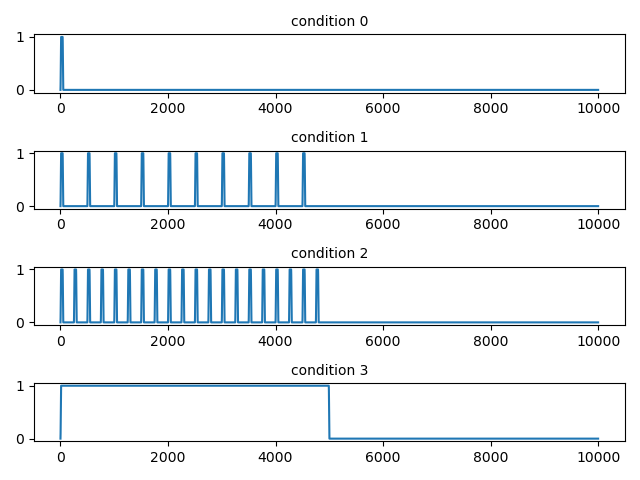

In [41]:
## opto_waveforms = waveforms passed to the LED for each condition
opto_waveforms = opto_data['opto_waveforms']
fig=plt.figure()
for ii in range(len(opto_waveforms)):
    ax=plt.subplot(len(opto_waveforms),1,ii+1)
    ax.plot(opto_waveforms[ii])
    ax.set_title('condition '+str(ii))
    
fig.tight_layout()

Make a dict to define the conditions

In [42]:
condition_names = {
    0: '5ms',
    1: '20hz',
    2: '40hz',
    3: '500ms',
}

In [43]:
condition_durs = {
    0: 0.005,
    1: 0.5,
    2: 0.5,
    3: 0.5,
}

Create the opto stim log

In [44]:
if len(opto_conditions) == len(opto_trial_rising):
    opto_log = pd.DataFrame({
        'stim_type': ['opto'] * len(opto_conditions),
        'parameter': [condition_names[x] for x in opto_conditions],
        'onset': opto_trial_rising,
        'offset': [np.nan] * len(opto_conditions),
        'duration': [condition_durs[x] for x in opto_conditions],
    })
else:
    print('Number of rising edges in opto_trial does not equal number of trials in opto.pkl.')

Add sweep number

In [45]:
opto_log['sweep'] = np.zeros(len(opto_log), dtype=int) - 1
for i in range(len(opto_sweep_rising)):
    # print('Sweep %d: %f to %f' % (i, sweep_start, sweep_end))
    opto_log.loc[(opto_log['onset'] >= opto_sweep_rising[i]) & (opto_log['onset'] <= opto_sweep_falling[i]), 'sweep'] = i

In [46]:
opto_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,opto,40hz,662.53143,NaN,0.500,0
1,opto,40hz,667.71253,NaN,0.500,0
2,opto,5ms,672.89563,NaN,0.005,0
3,opto,20hz,678.07722,NaN,0.500,0
4,opto,500ms,683.25715,NaN,0.500,0


## Combine logs into all_stim_log, sorted by onset times.

In [27]:
all_stim_log = pd.concat([estim_log], axis=0, sort=False).sort_values(by='onset', axis=0)

In [28]:
all_stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,biphasic,40,0.0004,1123.72310,1123.72350,0
1,biphasic,40,0.0004,1127.33018,1127.33058,0
2,biphasic,40,0.0004,1131.79251,1131.79291,0
3,biphasic,40,0.0004,1135.29757,1135.29797,0
4,biphasic,40,0.0004,1139.57292,1139.57332,0


## Save file to test whether index matters...

In [29]:
all_stim_log.to_csv(exp.stimulus_log_file, index=False)

### Load file to see index

In [38]:
test_log = pd.read_csv(exp.stimulus_log_file)
test_log[75:90]

,stim_type,parameter,onset,offset,duration,sweep
75,fullscreen,white,350.998493,351.264652,0.266159,0
76,fullscreen,white,355.719543,355.985222,0.265679,0
77,fullscreen,black,359.789243,360.055532,0.266289,0
78,fullscreen,white,363.926523,364.191892,0.265369,0
79,fullscreen,black,368.563643,368.829192,0.265549,0
80,fullscreen,black,425.444793,425.710392,0.265599,1
81,fullscreen,white,429.764563,430.031802,0.267239,1
82,fullscreen,white,433.851223,434.117452,0.266229,1
83,fullscreen,black,438.338433,438.604852,0.266419,1
84,fullscreen,black,442.158463,442.424512,0.266049,1


In [68]:
type(test_log.parameter.iloc[45])

str

In [70]:
print(test_log.parameter.iloc[45]=='55')

True


Hmm...combining the logs forces the amplitude to be a string...